# Very Quick Test Simulation with GROMACS

## Introduction
Adapted from a [GROMACS Tutorial](https://tutorials.gromacs.org/docs/md-intro-tutorial.html), this test seeks a brief molecular dynamics simulation between a small protein called `Factor Xa` (PDB code `1FJS`), and a co-crystallized ligand, called `INHIBITOR ZK-807834 (CI-1031)` (residue name `z34`). 

The objective of this exercise was to test my singularity image of `GROMACS` bundled with associated goodies as detailed in the singularity def file [obtained here](../.config/gromacs_2024.5-GPU.def).

The simulation time data is given below. For further background, see the MD-tutorials by Justin Lemkul @ http://www.mdtutorials.com/gmx/.

| Stage                | Purpose                                           | Ensemble | Duration | Time Step | Constraints          | Thermostat (T=300 K) | Barostat (P=1 bar)     | Notes |
|----------------------|---------------------------------------------------|----------|----------|-----------|----------------------|----------------------|------------------------|-------|
| Energy Minimization  | Relax bad contacts; remove steric clashes         | N/A      | ≤ 50,000 steps (until Fmax < 1000 kJ/mol/nm) | N/A       | None (or LINCS if needed) | None                 | None                   | Steepest descent (then CG optional) |
| NVT Equilibration    | Stabilize temperature; densify without pressure coupling | NVT      | 100 ps   | 2 fs      | LINCS on bonds to H  | V-rescale (tau_t=0.1 ps) | None                   | Position restraints on heavy protein & ligand atoms |
| NPT Equilibration    | Adjust density & pressure; stabilize volume       | NPT      | 100 ps   | 2 fs      | LINCS on bonds to H  | V-rescale (tau_t=0.1 ps) | Parrinello-Rahman (tau_p=2.0 ps) | Keep position restraints; isotropic coupling |
| Production MD        | Collect trajectory for analysis (dynamics, binding) | NPT      | 5 ns     | 2 fs      | LINCS on bonds to H  | V-rescale (tau_t=0.1 ps) | Parrinello-Rahman (tau_p=2.0 ps) | Remove restraints; save frames every 10 ps (e.g. nstxout-compressed=5000) |


The starting point for every simulation is a molecular structure file. In this tutorial, we will simulate Factor Xa - a protein playing a critical role in the formation of blood clots. The 3D structure is available from the RCSB website, https://www.rcsb.org/ with PDB code `1FJS`. You can find the PDB file for the crystal structure in the “input” directory as a file called `1fjs.pdb`.


### Notabene

For best results, launch this notebook on a browser with good webgl compatibility, like firefox or epiphany, not Google Chrome (at least not on linux).

In [1]:
import nglview as ng
import pandas as pd
import os
os.chdir("/home/daneel/gitrepos/gromacs_sims/protein-1fjs-ligand-z34-sim")
view = ng.show_structure_file("1fjs_protein.pdb")
view

NGLWidget()

## Cleaning the input structure
Once you’ve had a look at the molecule, you are going to want to strip out all the atoms that do not belong to the protein (e.i crystal waters, ligands, etc). To delete those atoms (labelled “HETATM” in the PDB file) and eventually their connectivity, either use a plain text editor like vi, emacs (Linux/Mac), or Notepad (Windows). Do not use word processing software! Alternatively, you can use `grep` to delete these lines very easily:

```bash
$ grep -v HETATM 1fjs.pdb > 1fjs_protein_tmp.pdb
$ grep -v CONECT 1fjs_protein_tmp.pdb > 1fjs_protein.pdb
```

Next, load into `pymol` the original `1fjs.pdb` that was downloaded from RCSB and use the sequence menu option to view the sequence. Use the mouse to select the residue labelled `z34` and save it into a separate pdb named `z34.pdb`. 

Now, you have two PDB files, the pure protein in `1fjs_protein.pdb`, and the ligand in `z34.pdb`.

## Molecular Protein-Ligand Docking

Next step is to dock the ligand into the protein optimally. To do so, use the `AMDock` tool after downloading and installing it from [their GitHub page](https://github.com/Valdes-Tresanco-MS/AMDock). Once the docking is finished, use pymol to prepare a protein-ligand complex PDB file with the ligand fully docked.  



## Note: Ligand protonation
Ligand protonation with openbabel is the default for this script, and ambertools is used in case openbabel fails. However, for this simulation, openbabel is also not working (yielding odd electrons). Therefore, we set the env var `PROTONATION_PREFER_AMBER` to `True` and reverse the order.

In [16]:
view = ng.show_structure_file("1fjs_protein_z34.pdb")
view

NGLWidget()

## Actual Simulation

Finally, use my handy-dandy python script to launch the simulation using the bioexel building blocks modules. For details, check out their website @ https://biobb-wf-protein-complex-md-setup.readthedocs.io/en/latest/index.html.

The default is to supply the input PDB with all atoms and molecules properly labelled and optimally docked. Then the script splits off the ligand (usually a small molecule) from the receptor (usually a protein, but a peptide or DNA/RNA segment or any combination of amino acids and/or nucleic acids should work just fine), protonates it if necessary, uses `acpype` to generate the ligand topology data (via stochastic gradient descent on the Hartree-Fock electronic ground state), then automagically follows the steps sequentially as indicated in the table above. Once the full production MD is complete, it post-processes the trajectory to remove artefacts and center the complex (labelled as 'Protein_Other'), making it ready for viewing and analysis.


In [1]:
import importmonkey
importmonkey.add_path("/home/daneel/gitrepos/gromacs_sims/scripts")
import biobb_protein_ligand_simulation as plsim

In [2]:
!pwd

/home/daneel/gitrepos/gromacs_sims/protein-1fjs-ligand-z34-sim


In [ ]:
import os
input_structure="1fjs_protein_z34.pdb"
ligand_code="Z34"
ligand_charge=0
outdir="simulation"
nprocs=12
usegpu=True
gpuid="0"
em_steps=5000

nvt_time_ns = 0.1
npv_time_ns = 0.1
md_time_ns = 5.0


npt_steps = int(npv_time_ns * 500000)
nvt_steps = int(nvt_time_ns * 500000)
md_steps = int(md_time_ns * 500000)

protein_1fjs_ligand_z34 = {
        'input_structure': input_structure,
        'ligand_code': ligand_code,
        'ligand_charge': ligand_charge,
        'outdir': outdir,
        'nprocs': nprocs,
        'usegpu': usegpu,
        'gpuid': gpuid,
        'em_steps': em_steps,
        'npt_steps': npt_steps,
        'nvt_steps': nvt_steps,
        'md_steps': md_steps
    }


os.environ["PROTONATION_PREFER_AMBER"] = "True"
plsim.molecular_dynamics(protein_1fjs_ligand_z34, protonated=False)

### Visualization

Use `MDAnalysis` and `nglview` to visualize the `xtc` trajectory.

In [2]:
import MDAnalysis as mda
top_file = "simulation/prot_1fjs_protein_z34_Z34_md_dry.gro"
traj_file = "simulation/prot_1fjs_protein_z34_Z34_cluster_center_traj.xtc"
ligand_code = "Z34"
u = mda.Universe(top_file, traj_file)

prot_lig = u.select_atoms("protein or resname " + ligand_code) 
view = ng.show_mdanalysis(prot_lig)
view.center(selection='resname'+ligand_code)
view.add_contact(selection=prot_lig,hydrogen_bond=True)
view

NGLWidget(max_frame=5000)

# Post-Processing

First, create a "Dry-`tpr`" binary-topology file using selections `Protein_Other` defined in the index file `prot_1fjs_protein_z34_Z34_index.ndx`. This way, the topology will match the dry trajectory files.


In [4]:
import subprocess
old_tpr_file = "simulation/prot_1fjs_protein_z34_Z34_gppmd.tpr"
dry_tpr_file = "simulation/prot_1fjs_protein_z34_Z34_md_dry.tpr"
ndx_file = "simulation/prot_1fjs_protein_z34_Z34_index.ndx"

proc = subprocess.run(
    ["gmx", "convert-tpr", "-s", old_tpr_file, "-n", ndx_file, "-o", dry_tpr_file],
    input="Protein_Other\nq\n",    # <-- pass a str when text=True
    text=True,
    capture_output=True,
)
print("gmx convert-tpr exit:", proc.returncode)
print(proc.stdout)
if proc.returncode != 0:
    print("gmx convert-tpr failed, stderr:")
    print(proc.stderr)
    proc.check_returncode()

gmx convert-tpr exit: 0
Selected 20: 'Protein_Other'



Next, do all trajectory size and structure analysis based on the dry tpr file.

### RMSD Calculation

Root mean square deviation of backbone atoms from initial coordinates at each time frame, plotted vs time.

  0%|          | 0/5001 [00:00<?, ?it/s]

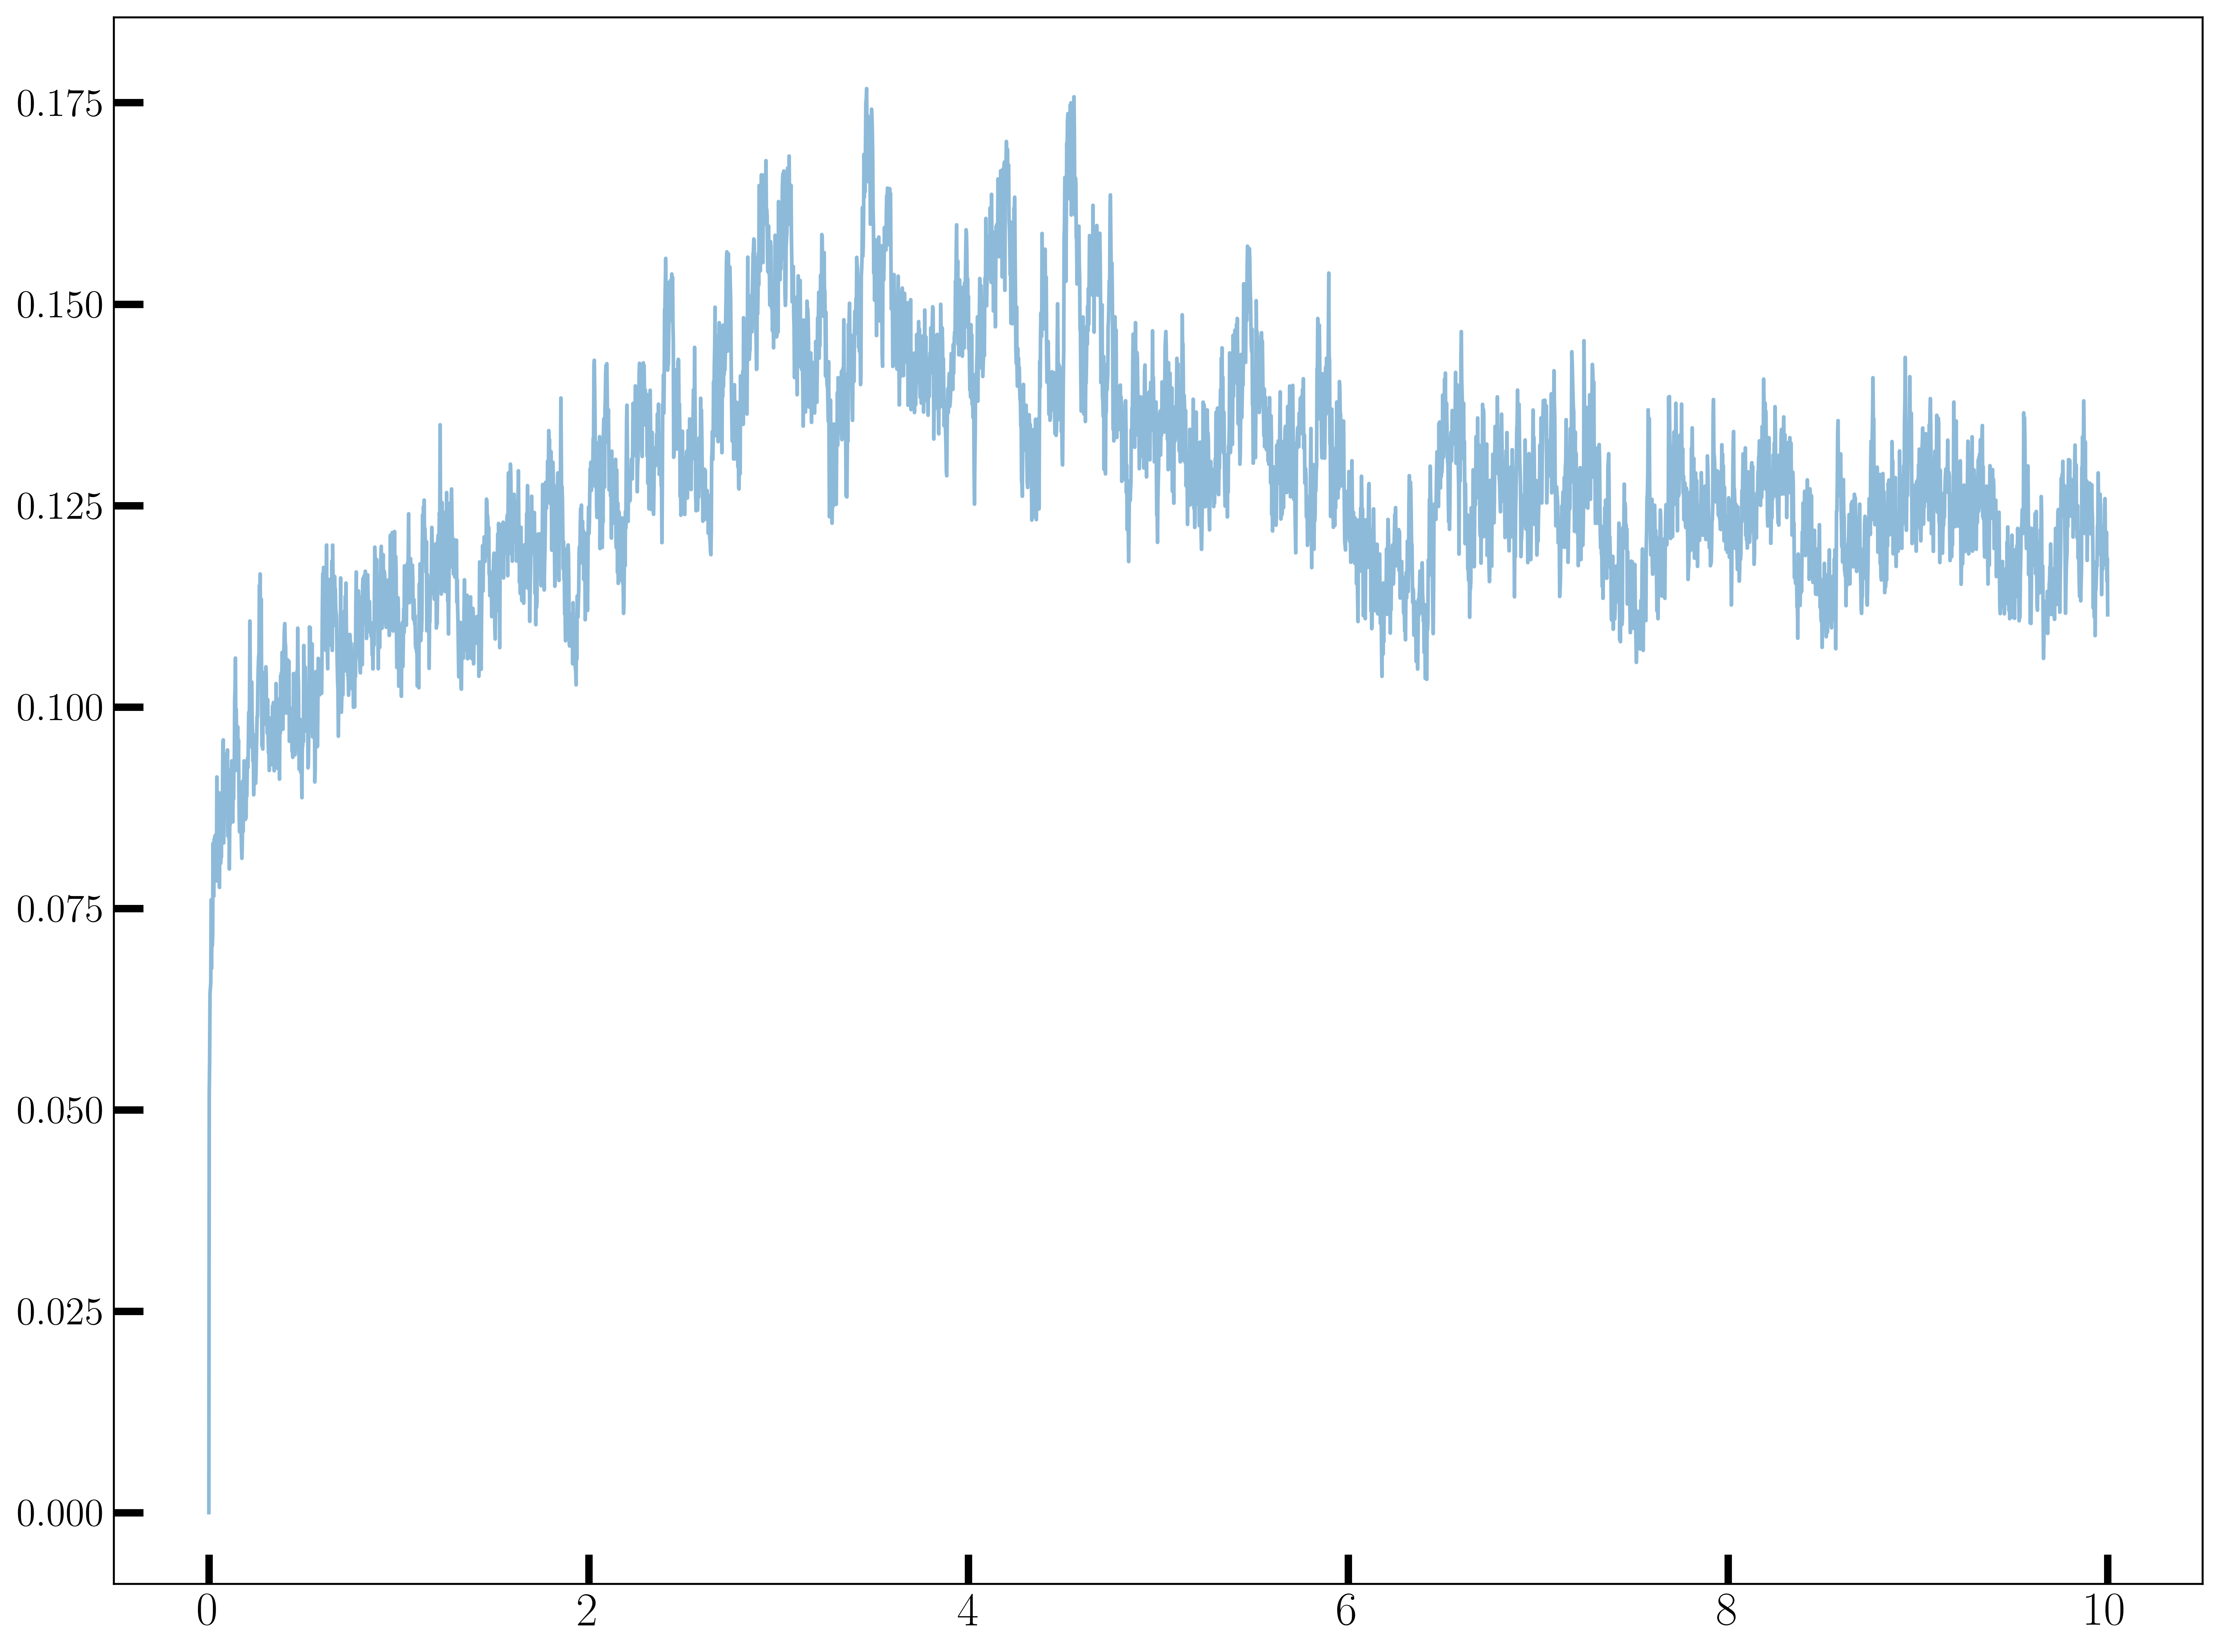

In [13]:
from MDAnalysis.analysis import rms
import matplotlib.pyplot as plt

top_file = dry_tpr_file
traj_file = "simulation/prot_1fjs_protein_z34_Z34_cluster_center_traj.xtc"
ligand_code = "Z34"
u = mda.Universe(top_file, traj_file)

R = rms.RMSD(u,  # universe to align
    u,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]
plt.plot(times_c/1000, rmsd_c/10, alpha=0.5)

### RMSF Calculation

Root-mean-square deviation in time for the atoms of each amino acid residue, plotted vs residue-id.


  0%|          | 0/5001 [00:00<?, ?it/s]

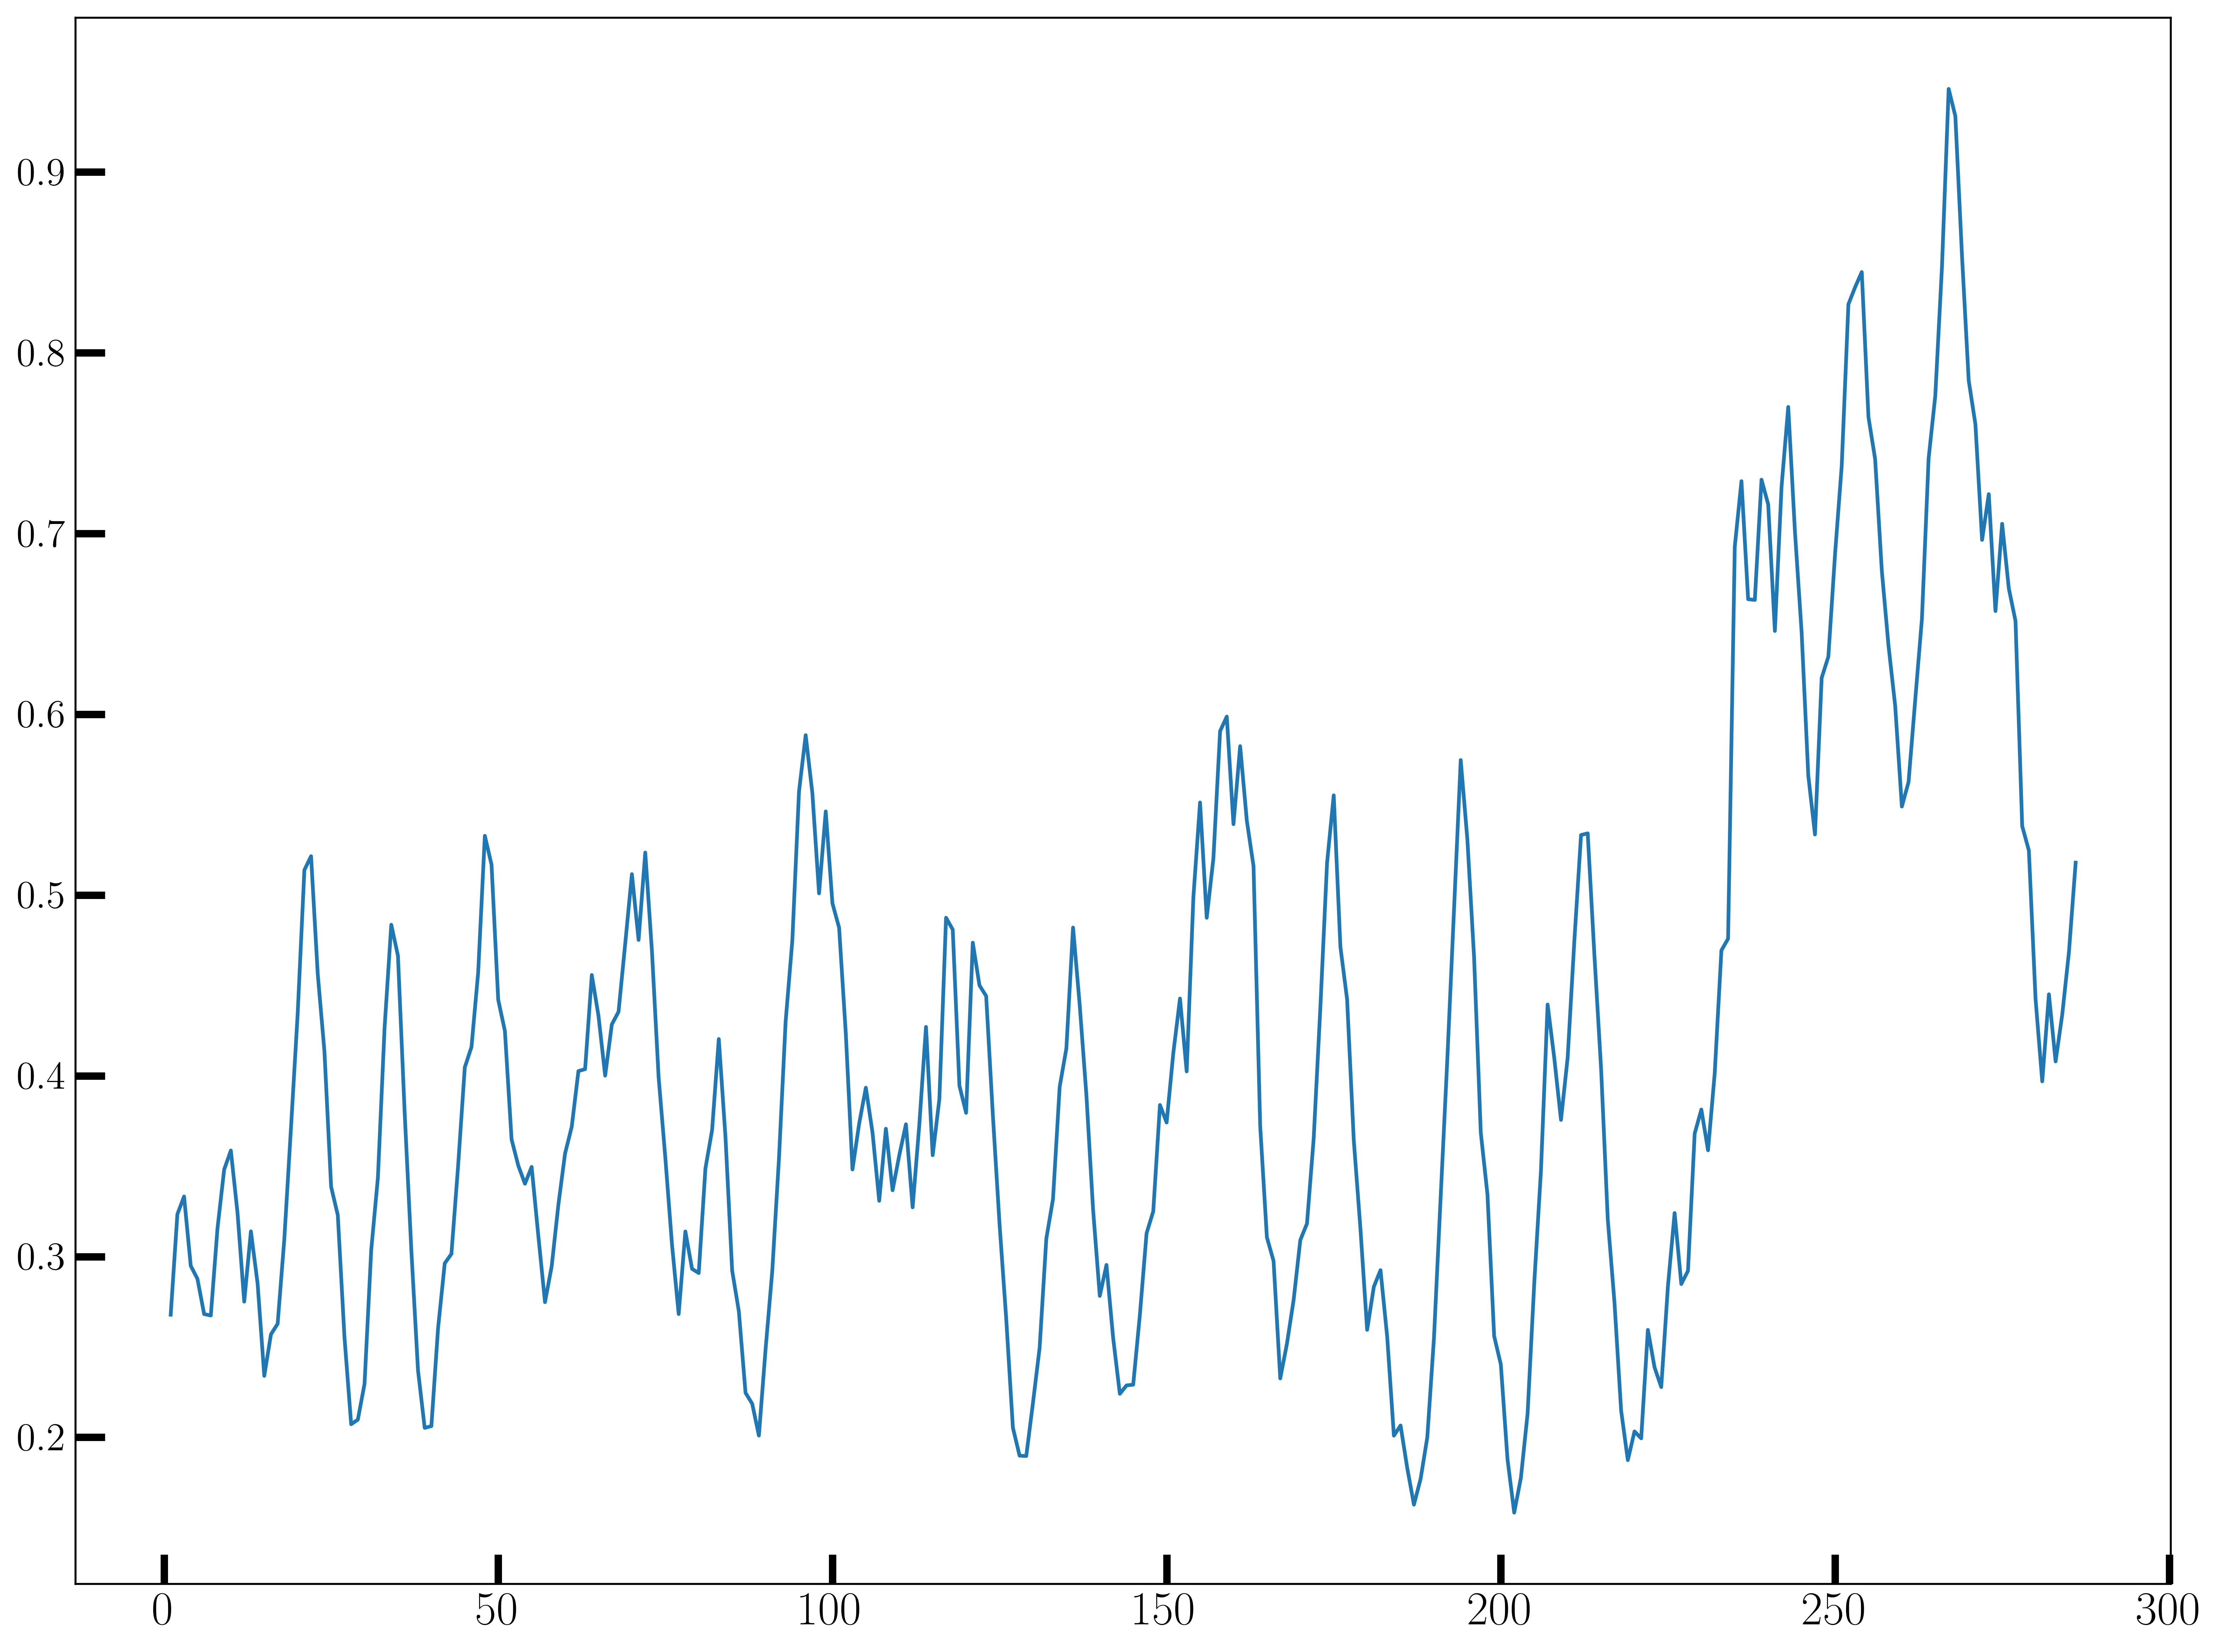

In [22]:
c_alphas_c = u.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)
plt.plot(c_alphas_c.resids, R_c.results.rmsf/10)

### Radius of Gyration (Rg) Calculation

Radius of gyration of the protein vs time.

  0%|          | 0/5001 [00:00<?, ?it/s]

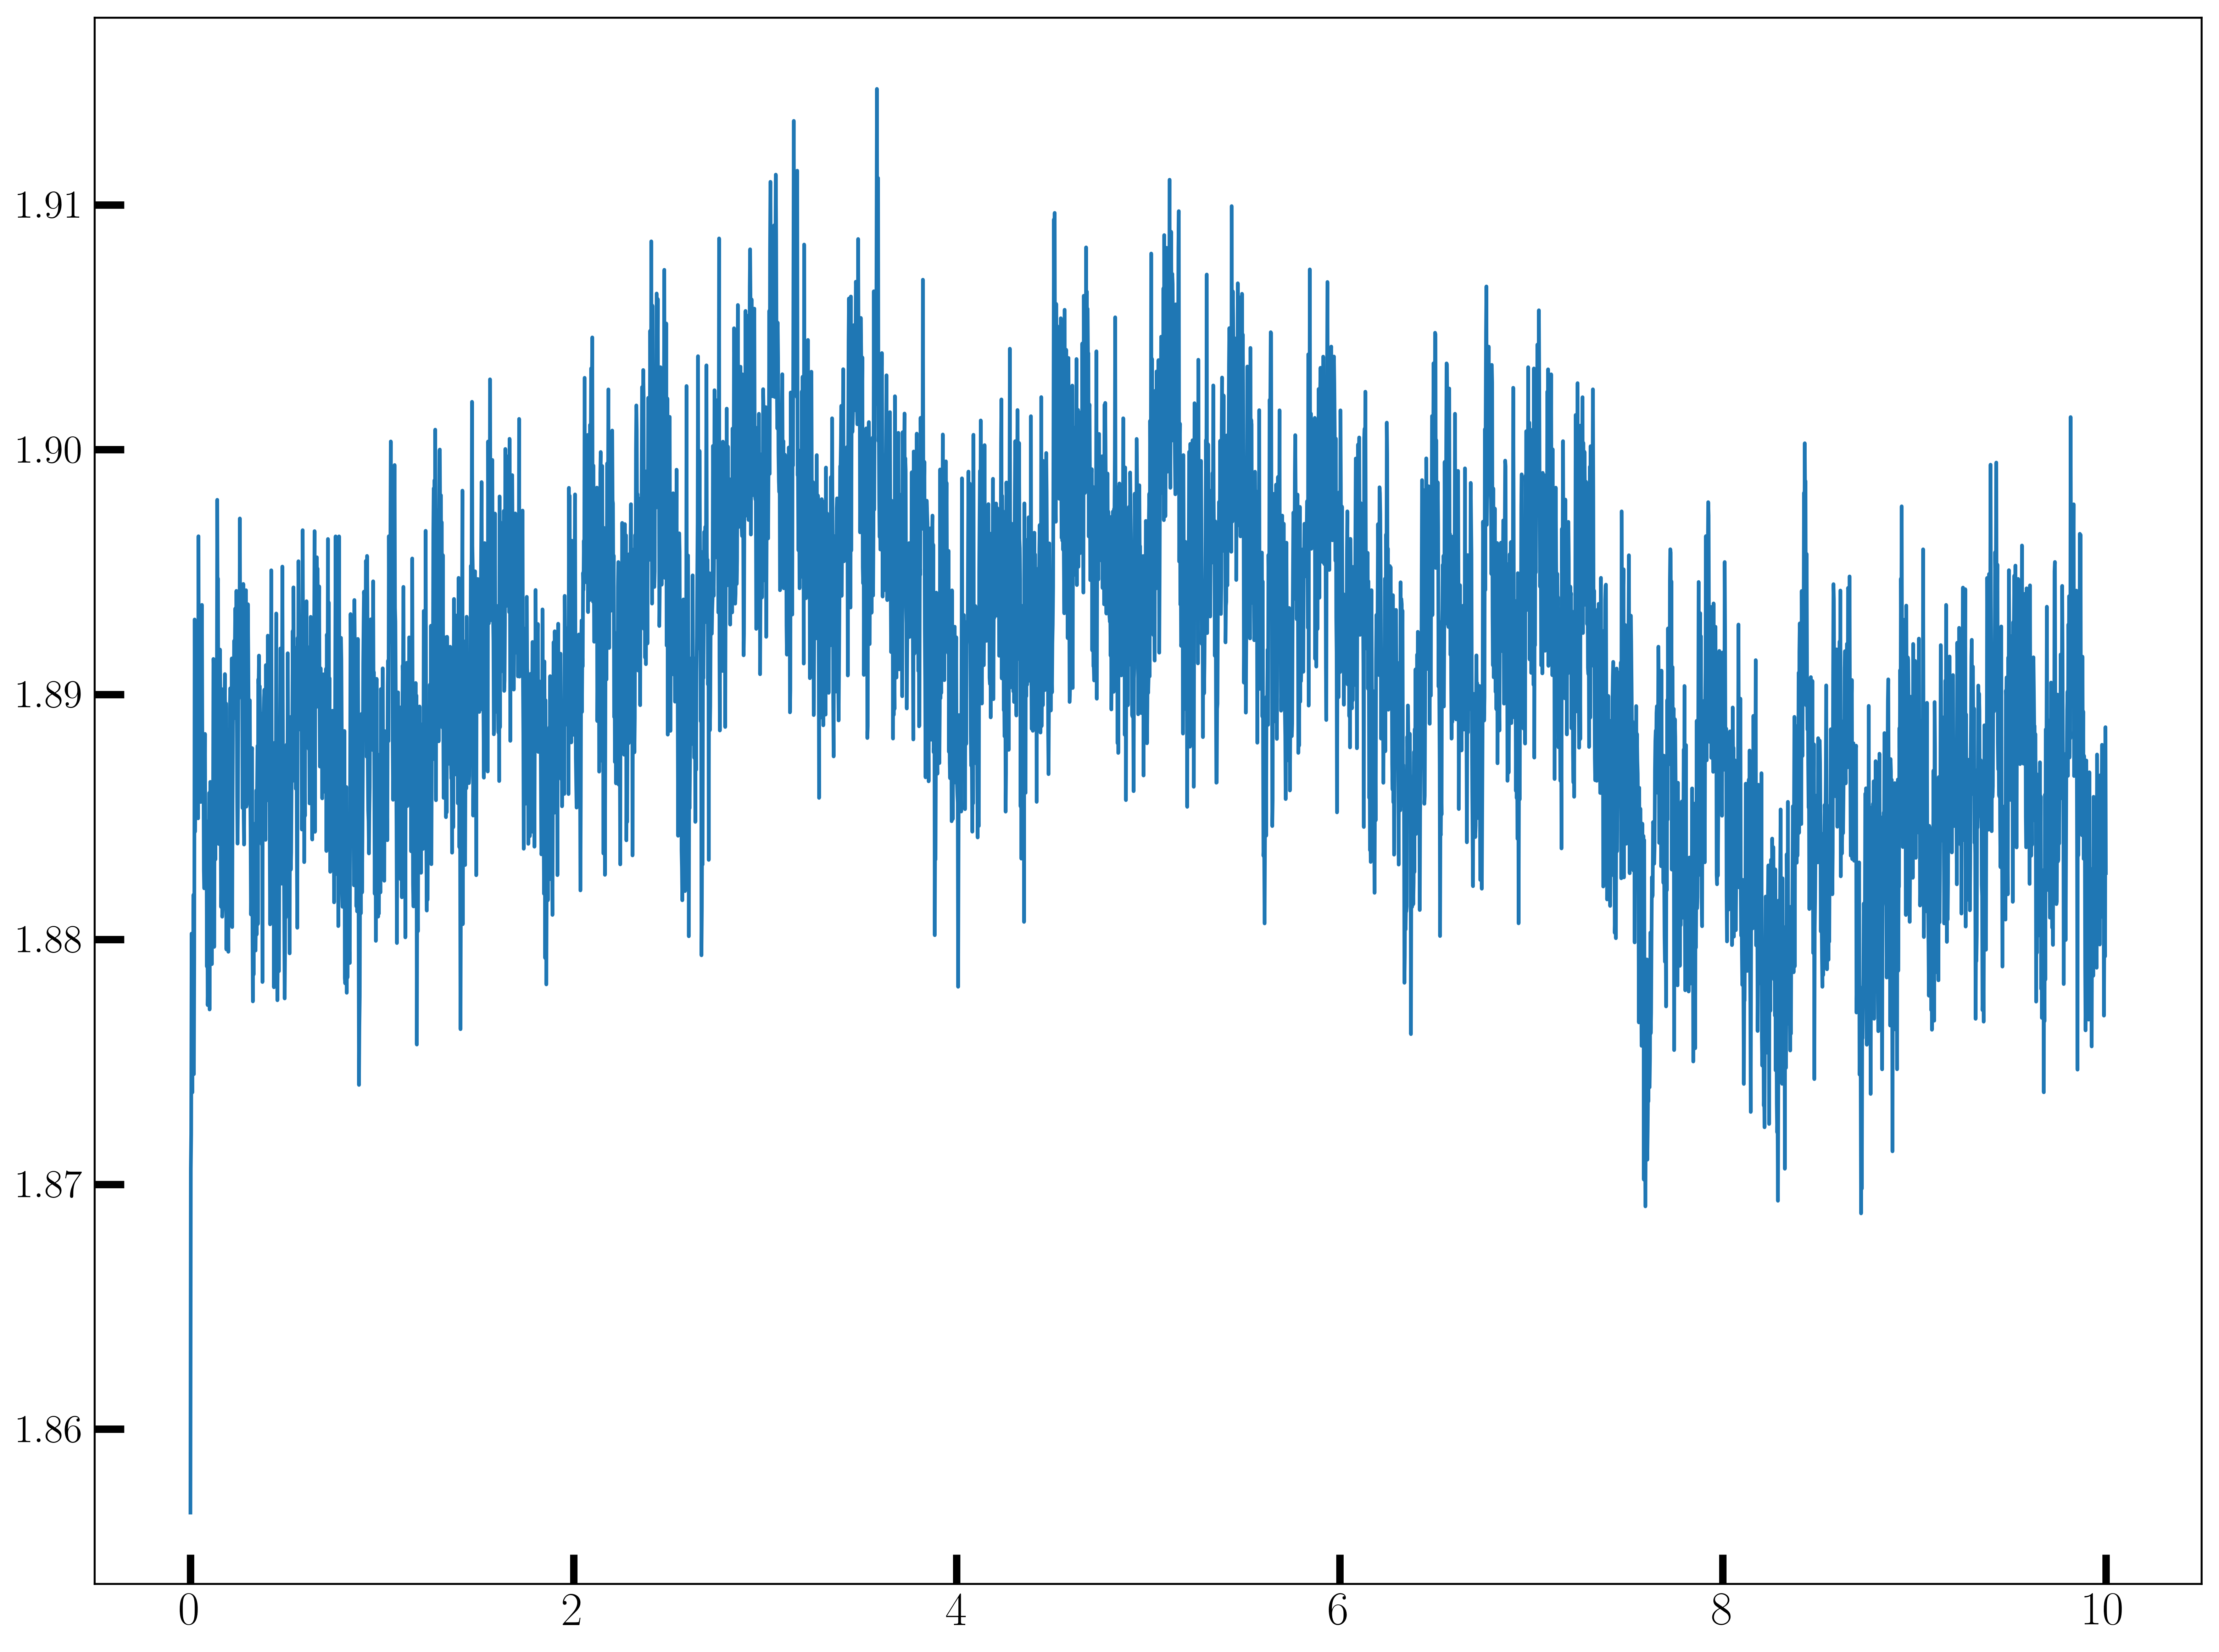

In [23]:
from tqdm.notebook import tqdm
import numpy as np
group = u.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(u.trajectory):
	Frame.append(ts.frame)
	times.append(u.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10)

### Hydrogen bond analysis


***TODO***

### Principal Component Analysis

What follows is a more automate version of the PCA done on earlier simulations like MMP9-SB3CT or the ColPk-Pm-ligand simulations.

We will do the PCA using the same workflow as those using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`.

***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.


First, select backbone-or-ligand from MDAnalysis universe. Then, get covariance matrix, then diagonalize it to get eigenvalues and eigenvectors. Sort in descending order.


Covariance matrix is given by

\begin{align*}
C &=& \left\vert \overline{\vec{q}(t)-\overline{\vec{q}}}\right\rangle\left\langle \overline{\vec{q}(t)-\overline{\vec{q}}}\right\vert  \\
\overline{\vec{X}} &=& \frac{1}{T}\int^T_0\vec{X}(t)\;dt.
\end{align*}

Here, $\vec{X}(\vec{q},t)$ is any vector function of all selected coordinates $\vec{q}$ (including $\vec{q}$ itself), and the overline denotes time average over the entire simulation time $T$.

In [5]:
import MDAnalysis as mda
dry_tpr_file = "simulation/prot_1fjs_protein_z34_Z34_md_dry.tpr"
traj_file = "simulation/prot_1fjs_protein_z34_Z34_cluster_center_traj.xtc"
ligand_code = "Z34"
u = mda.Universe(dry_tpr_file, traj_file)

In [6]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt


# Select backbone + ligand (adjust ligand name if needed)
sel = u.select_atoms("backbone or resname " + ligand_code)

# Collect coordinates across frames
coords = []
for ts in u.trajectory:
    coords.append(sel.positions.flatten())  # shape (3N,)
coords = np.array(coords)

# Subtract mean structure
mean_coords = coords.mean(axis=0)
coords_centered = coords - mean_coords

# Compute covariance matrix
cov = np.cov(coords_centered, rowvar=False)

# Diagonalize
eigvals, eigvecs = np.linalg.eigh(cov)

# Sort descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Compute cumulative percentage of variance explained
cumvar =100 - np.cumsum(eigvals) / np.sum(eigvals) * 100


In [10]:
sel, coords_centered.shape, cov.shape

(<AtomGroup with 1204 atoms>, (5001, 3612), (3612, 3612))

#### Plot of cumulative variance of eigenvalues of cov

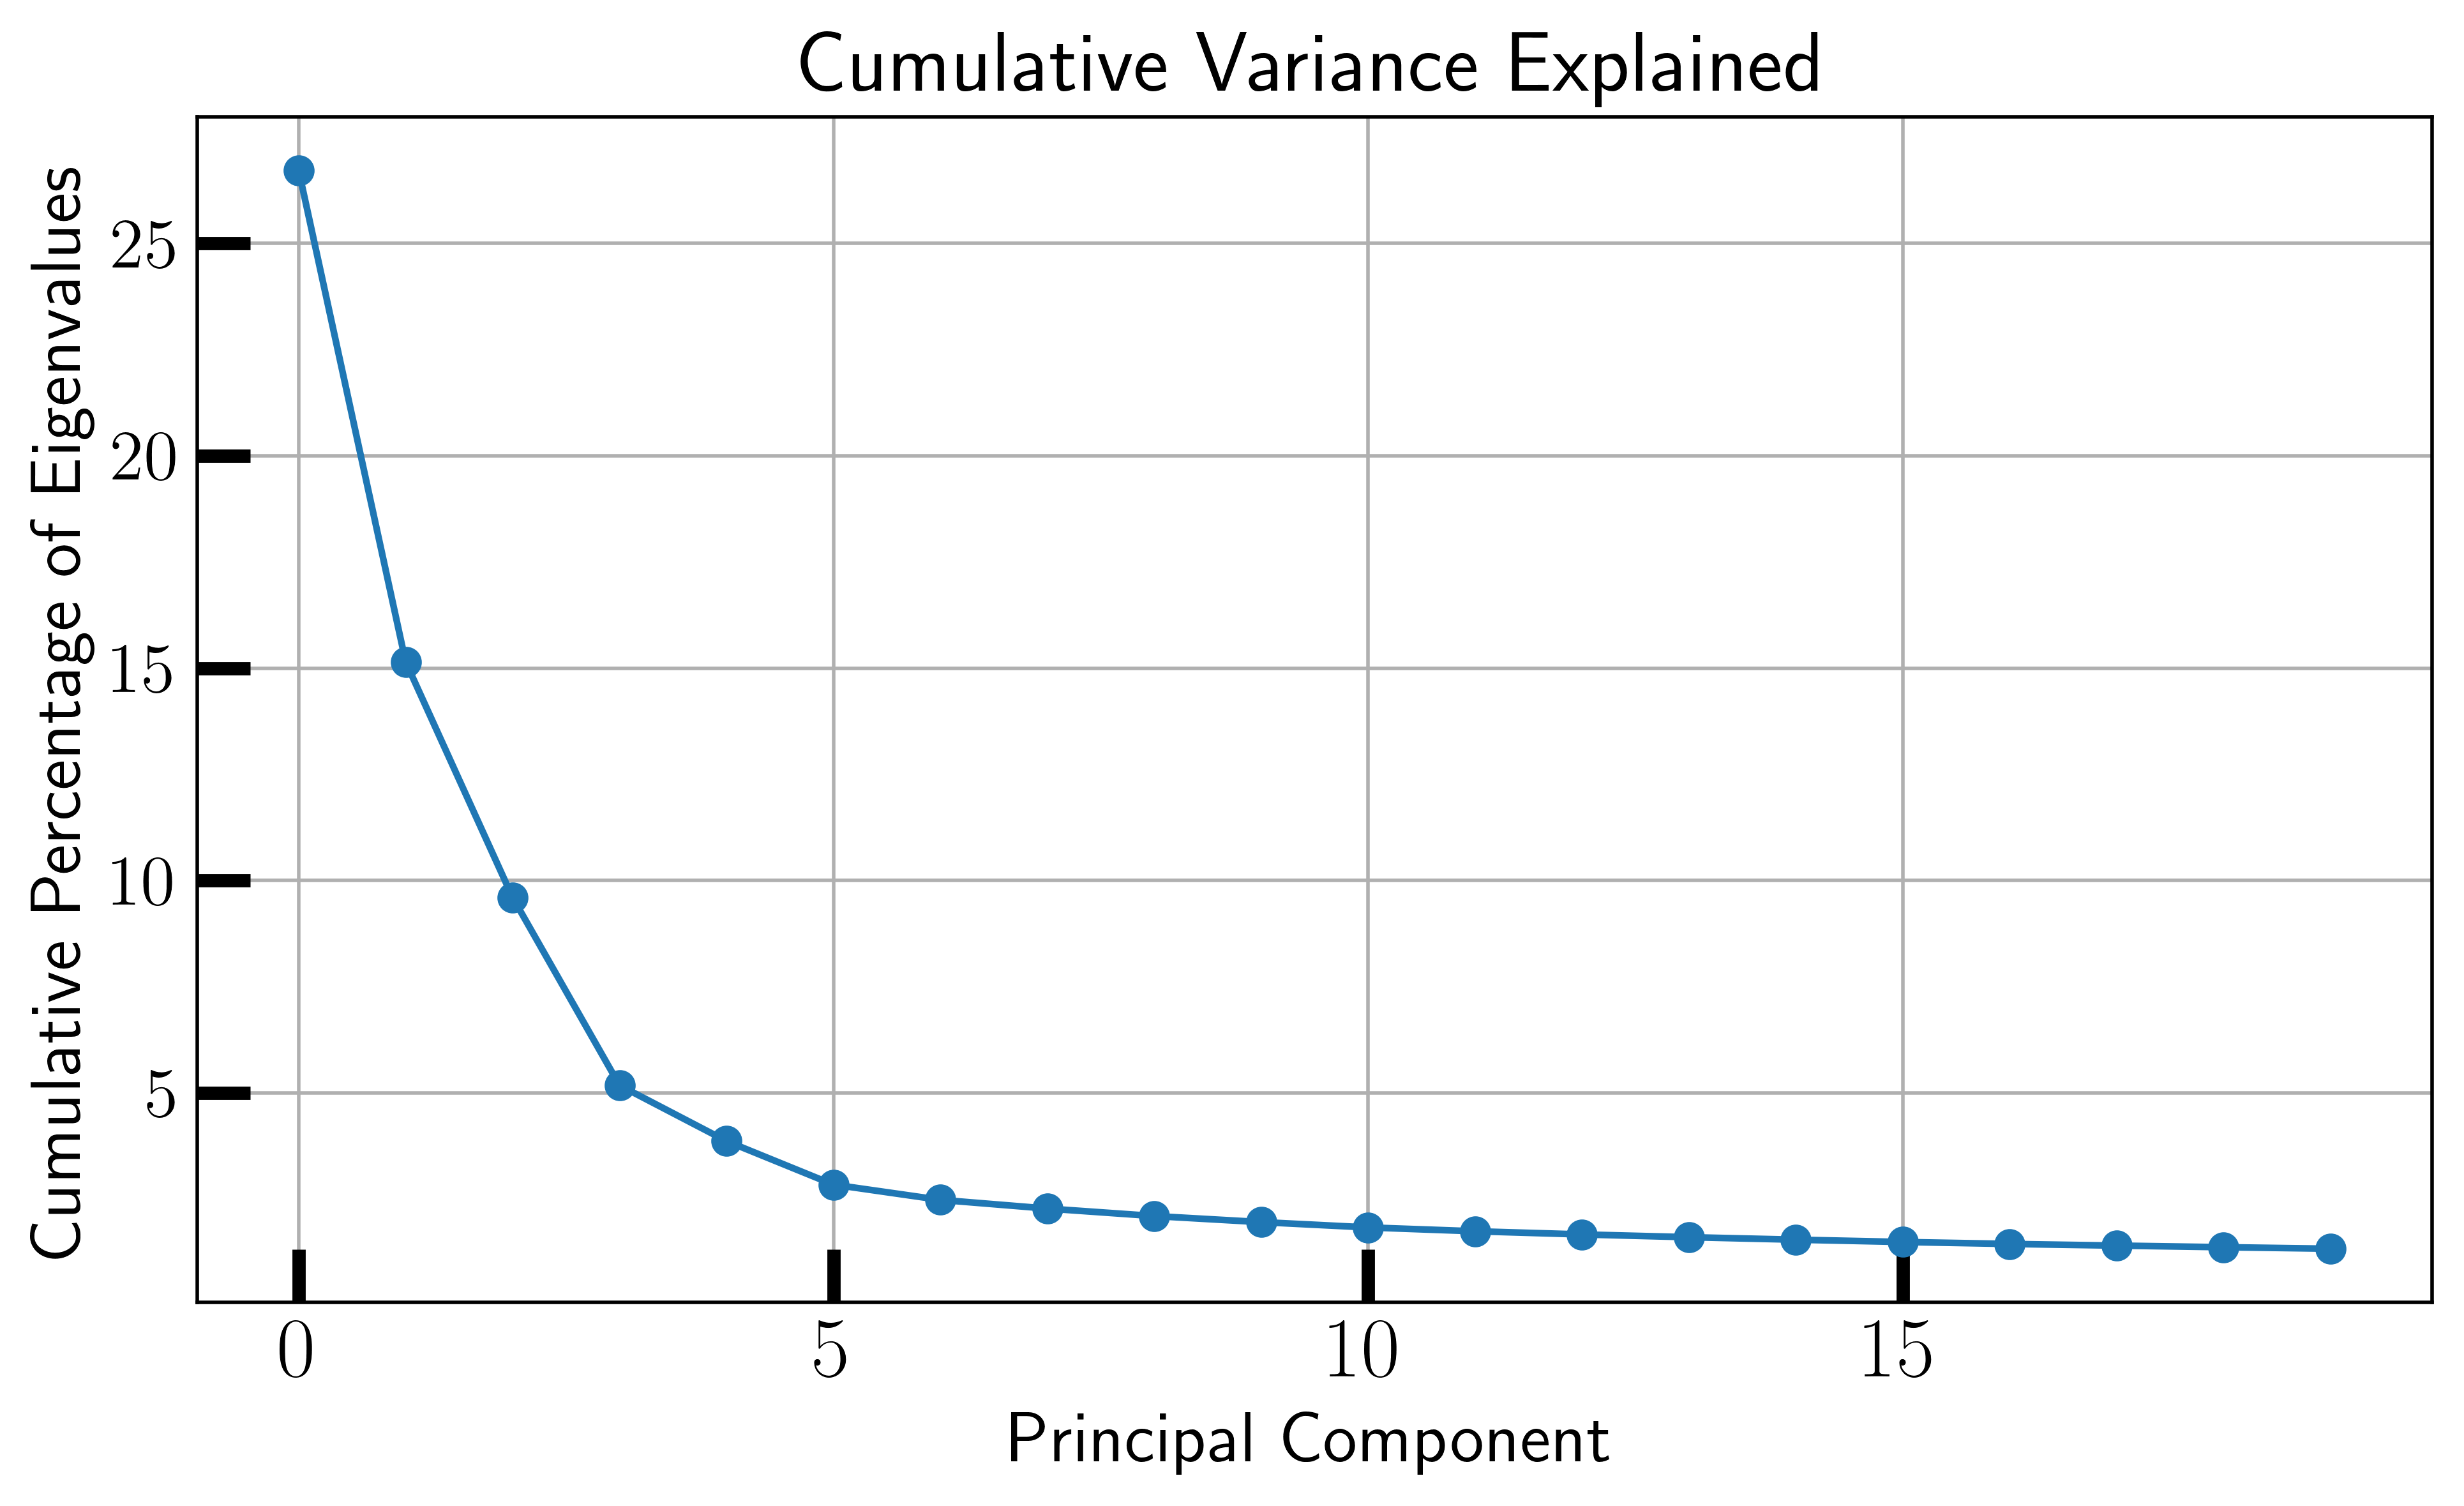

In [ ]:
# Plot cumulative variance explained
plt.figure(figsize=(8,5))
plt.plot(cumvar[0:20], marker='o')
plt.xlabel('Principal Component')
plt.title('Cumulative Variance Explained')
plt.ylabel('Cumulative Percentage of Eigenvalues')
plt.grid(True)
plt.tight_layout()
plt.show()

Next, we select the two most dominant eigenvalues (can choose more if they're comparable) and project the full trajectory into their eigenvector-spanned subspace. This is computed using the vector operations
\begin{equation*}
PC(t) = Q(t) \cdot U^T
\end{equation*}
where the matrix $U$ diagonalizes the covariance matrix (eigenvectors arranged columnwise as in linear algebra texts), and the matrix $Q$ is given by
\begin{equation*}
Q_{ij} = q_j(t_i)
\end{equation*}
Therefore, we have
\begin{equation*}
PC_{ij} = \sum_k q_k(t_i)U_{jk}
\end{equation*}
for the $i^{th}$ time and $j^{th}$ selection atm co-ordinate. No first look at $PC_{1,2}$ vs time, then at $PC_1$ vs $PC_2$ with time $t$ as a curve length parameter.

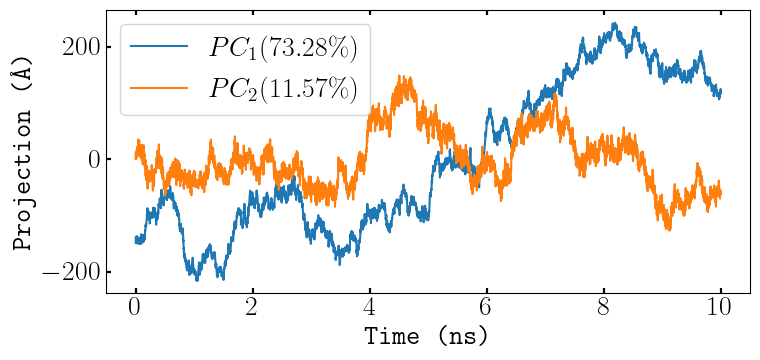

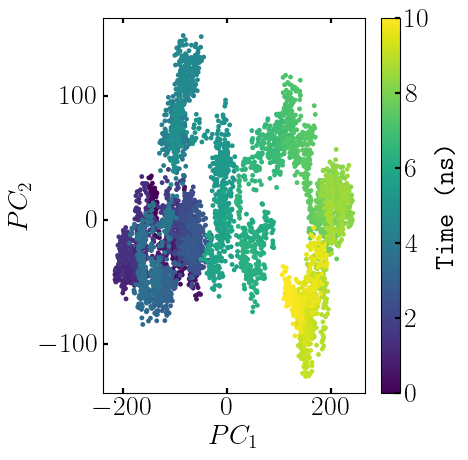

In [12]:
n = 2
evecs_top = eigvecs[:, :n]                       # shape (3N, n)
projections = coords_centered @ evecs_top     # shape (n_frames, n)
proj = projections                               # keep a concise name for later use

times = [ts.time for ts in u.trajectory]
# quick time axis in ns
t_ns = np.array(times) / 1000.0

# plot time series of top-n projections
plt.figure(figsize=(8,4))
for i in range(n):
    pct = eigvals[i] / eigvals.sum() * 100
    plt.plot(t_ns, proj[:, i], label=fr'$PC_{i+1} ({pct:.2f}\%)$')
plt.xlabel('Time (ns)')
plt.ylabel('Projection (Å)')
plt.legend()
plt.tight_layout()
plt.show()

# If at least 2 components, plot PC1 vs PC2 colored by time
if n >= 2:
    plt.figure(figsize=(5,5))
    sc = plt.scatter(proj[:, 0], proj[:, 1], c=t_ns, s=6, cmap='viridis')
    plt.xlabel(r'$PC_1$')
    plt.ylabel(r'$PC_2$')
    plt.colorbar(sc, label='Time (ns)')
    plt.tight_layout()
    plt.show()

Finally, use histogram binning of $PC_i$ vs $PC_j$, followed by Boltzmann inversion, to estimate the Free-energy landscape (FEL) $\Delta G(x,y)$ in the $PC_{1,2}$ plane. Here, 
\begin{equation*}
P(x,y) \propto e^{-\Delta G(x,y)/k_BT}
\end{equation*}
at room temperature $T$ and planar coordinates $x,y$. The binning yields $P(x,y)$. Note that this is the expected $NpT$ensemble where in which the production run simulation is run by default (see table above, as well as the [biobb MD simulation docs](https://biobb-wf-protein-complex-md-setup.readthedocs.io/en/latest/tutorial.html)).

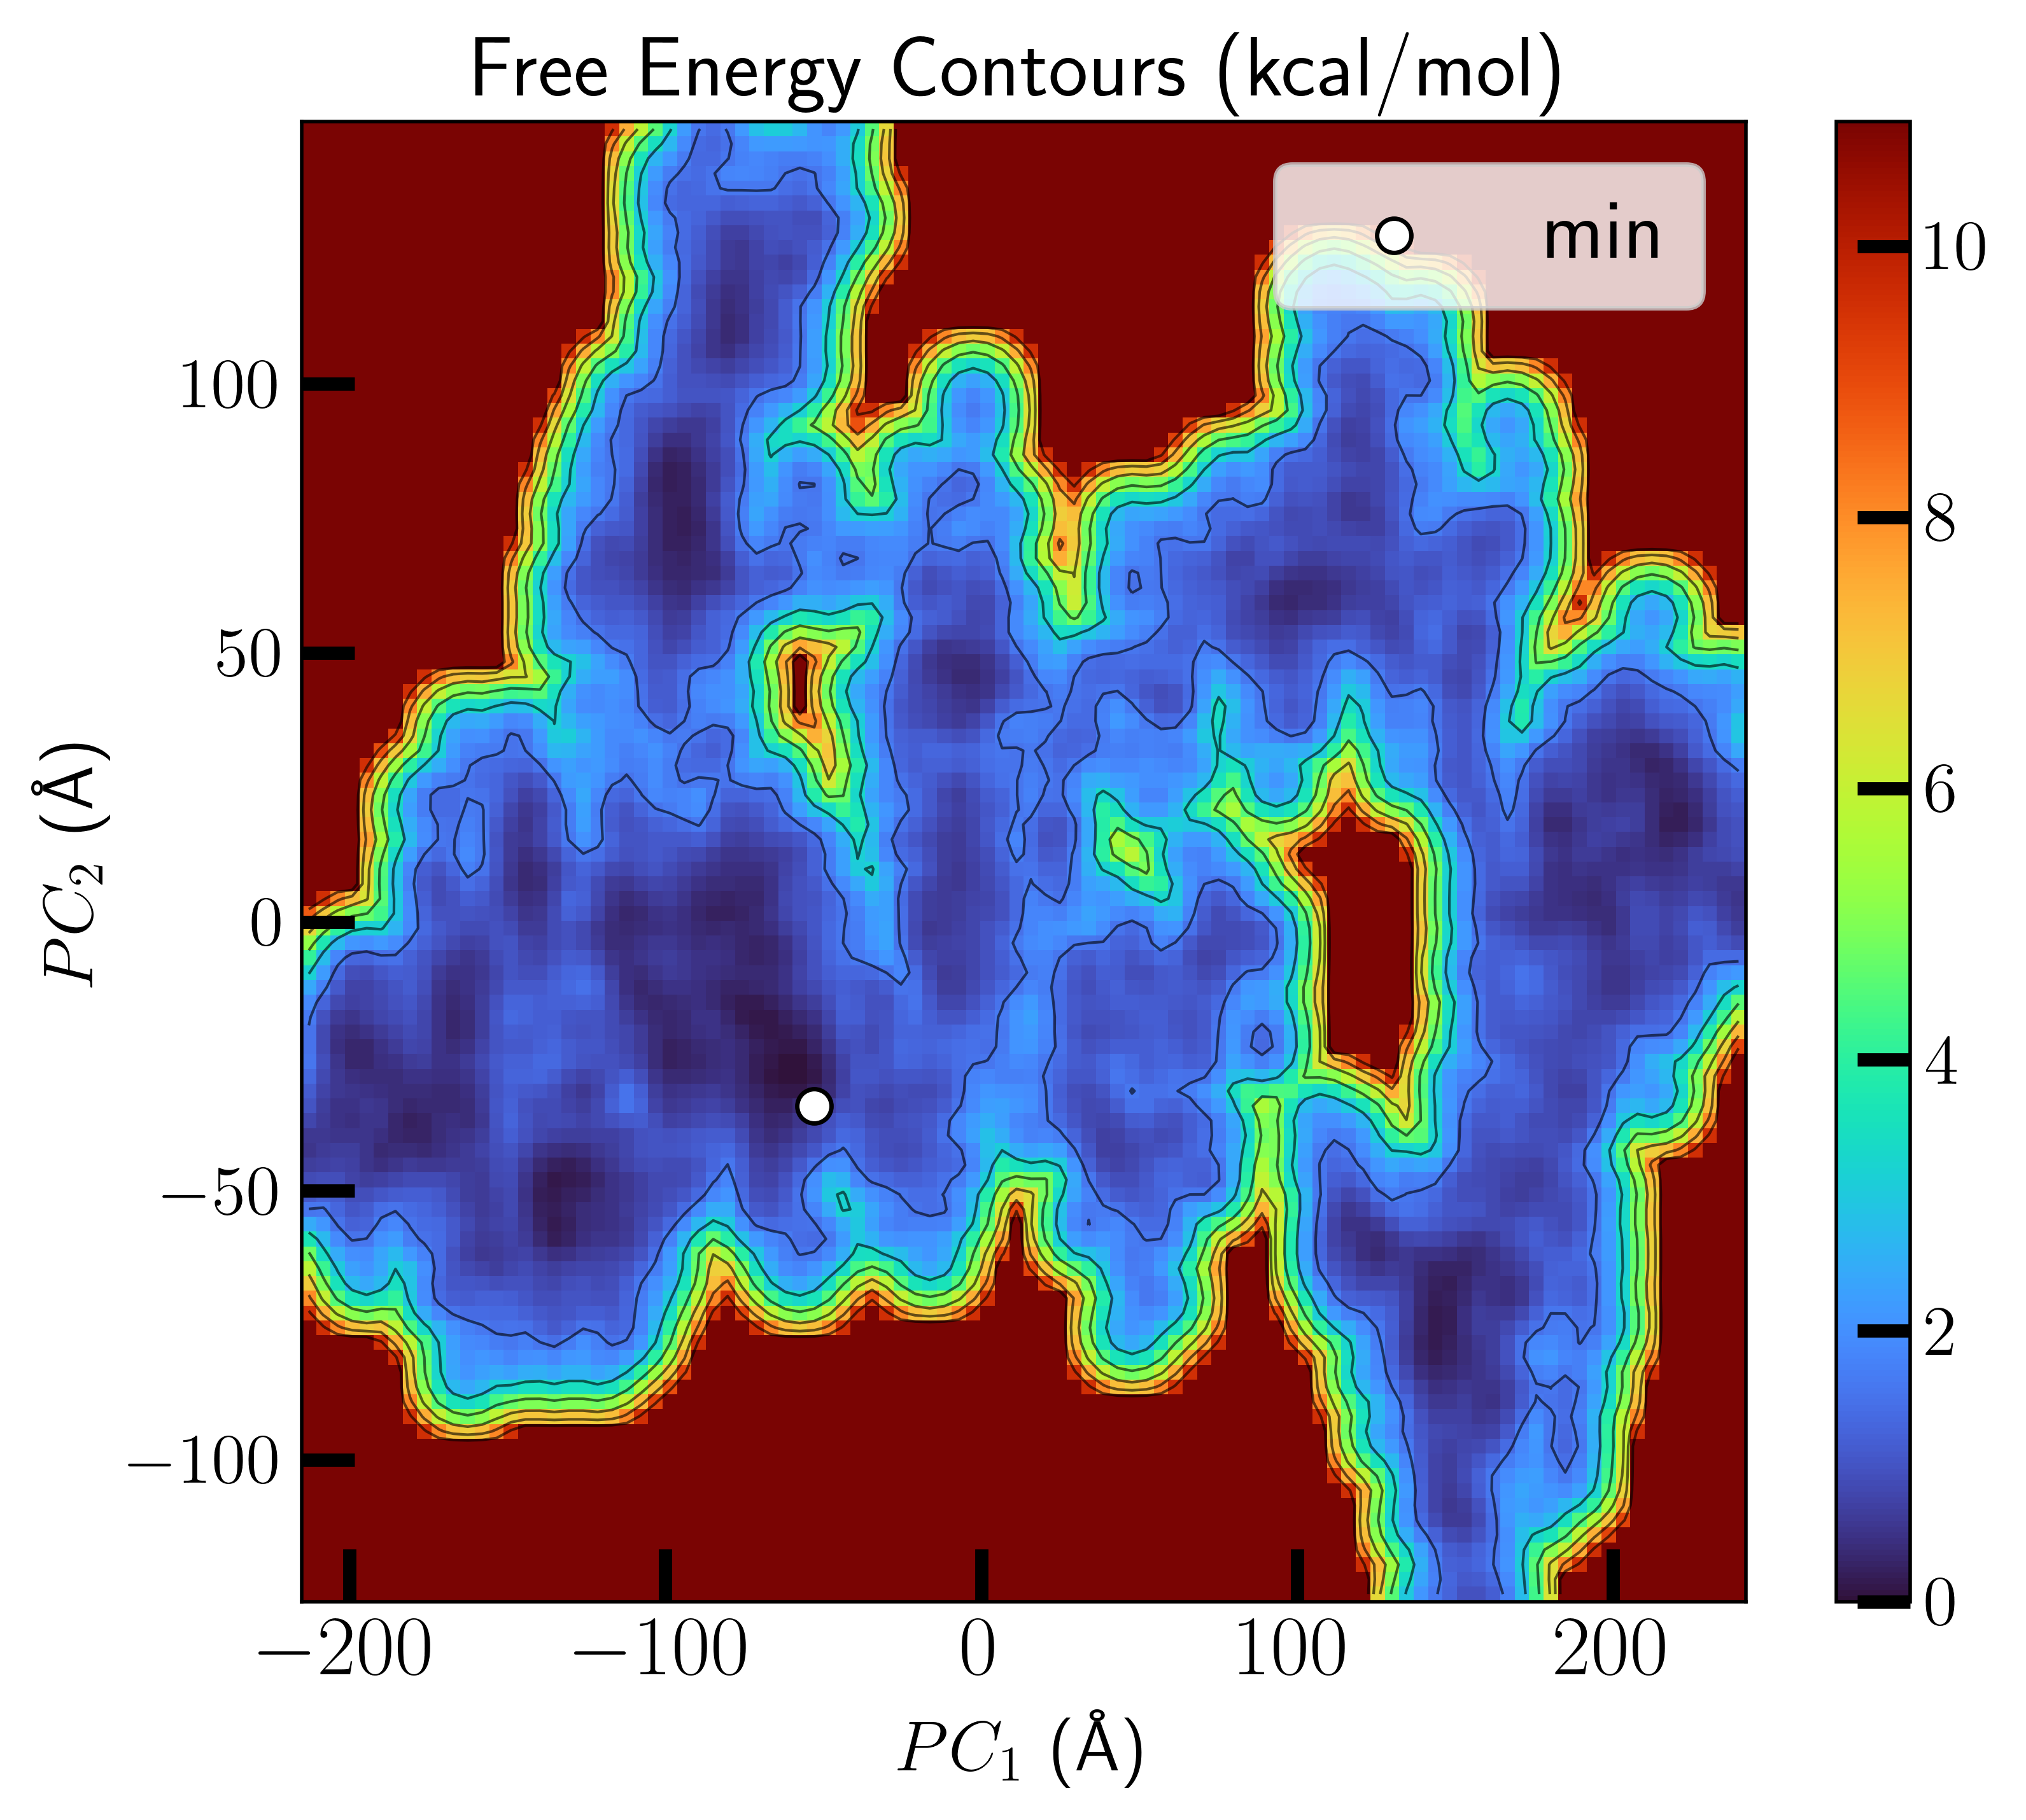

In [58]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Compute 2D Free Energy Surface (FES) from the top-2 projections (similar to gmx sham)
# Uses existing variables: proj (shape (n_frames,2)), t_ns (time axis, ns)
import matplotlib.pyplot as plt
kB = 0.0019872  # kcal mol^-1 K^-1
# Parameters
T = 300.0                                # temperature [K]
beta = 1.0 / (kB * T)                    # 1/(kB*T)
bins = 100                               # histogram bins per axis
smooth_sigma = 1.0                       # gaussian smoothing sigma (in histogram bins)
min_prob = 1e-12                         # floor probability to avoid log(0)

# data (use existing projections)
x = proj[:, 0].astype(float)
y = proj[:, 1].astype(float)

# 2D histogram (density estimate)
H, xedges, yedges = np.histogram2d(x, y, bins=bins, density=True)
#  smooth (use scipy if available
H_s = gaussian_filter(H, sigma=smooth_sigma)

# convert to free energy: F = -kT ln P ; use floor to avoid -inf
H_s[H_s < min_prob] = min_prob
F = - (1.0 / beta) * np.log(H_s)         # in kcal/mol
F -= F.min()                            # set global minimum to 0

# grid for plotting
Xc = 0.5 * (xedges[:-1] + xedges[1:])
Yc = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(Xc, Yc, indexing='xy')

# find minima location(s)
min_idx = np.unravel_index(np.nanargmin(F), F.shape)
xmin = X[min_idx]
ymin = Y[min_idx]
Fmin = F[min_idx]

# Plot 2D FES
plt.figure(figsize=(7,6))
pcm = plt.pcolormesh(xedges, yedges, F.T, shading='auto', cmap='turbo')
cbar = plt.colorbar(pcm)
levels = np.linspace(0, np.clip(F.max(), 5, 20), 8)
plt.contour(X, Y, F.T, levels=levels, colors='k', linewidths=0.6, alpha=0.6)
plt.scatter([xmin], [ymin], color='white', edgecolor='k', s=60, label=f'min')
plt.xlabel(r'$PC_1$  (Å)')
plt.ylabel(r'$PC_2$  (Å)')
plt.title('Free Energy Contours (kcal/mol)')
plt.legend()
plt.tight_layout()
plt.show()

#### PMF (Potential of Mean Force) — concise summary

What it is: a free‑energy profile along a chosen coordinate (reaction coordinate or collective variable).

Formula: PMF(x) = −kB T ln[P(x)] + constant, where P(x) is the probability density of observing coordinate x, kB is Boltzmann’s constant and T the temperature.

Units & meaning: usually reported in kJ/mol or kcal/mol; differences give free‑energy differences (ΔG = PMF(x2) − PMF(x1)). Minima = stable states; peaks = barriers controlling kinetics.

How it’s obtained: from histogramming trajectories (as in your notebook), or enhanced‑sampling methods (umbrella sampling + WHAM, metadynamics, steered MD, etc.).
Caveats: depends on choice of coordinate, requires good sampling/convergence, and an arbitrary additive constant (only differences are meaningful).

H_s is the 2D (smoothed) density on the PC1×PC2 grid returned by np.histogram2d (shape: (nx, ny) where nx = #bins in x/PC1, ny = #bins in y/PC2).

#### Notes:

`np.histogram2d(..., density=True)` yields a probability density; to get per‑bin probabilities you would multiply by bin area, but a uniform bin-area factor only shifts the PMF by a constant (which is removed by subtracting the minimum), so the differences stay correct.

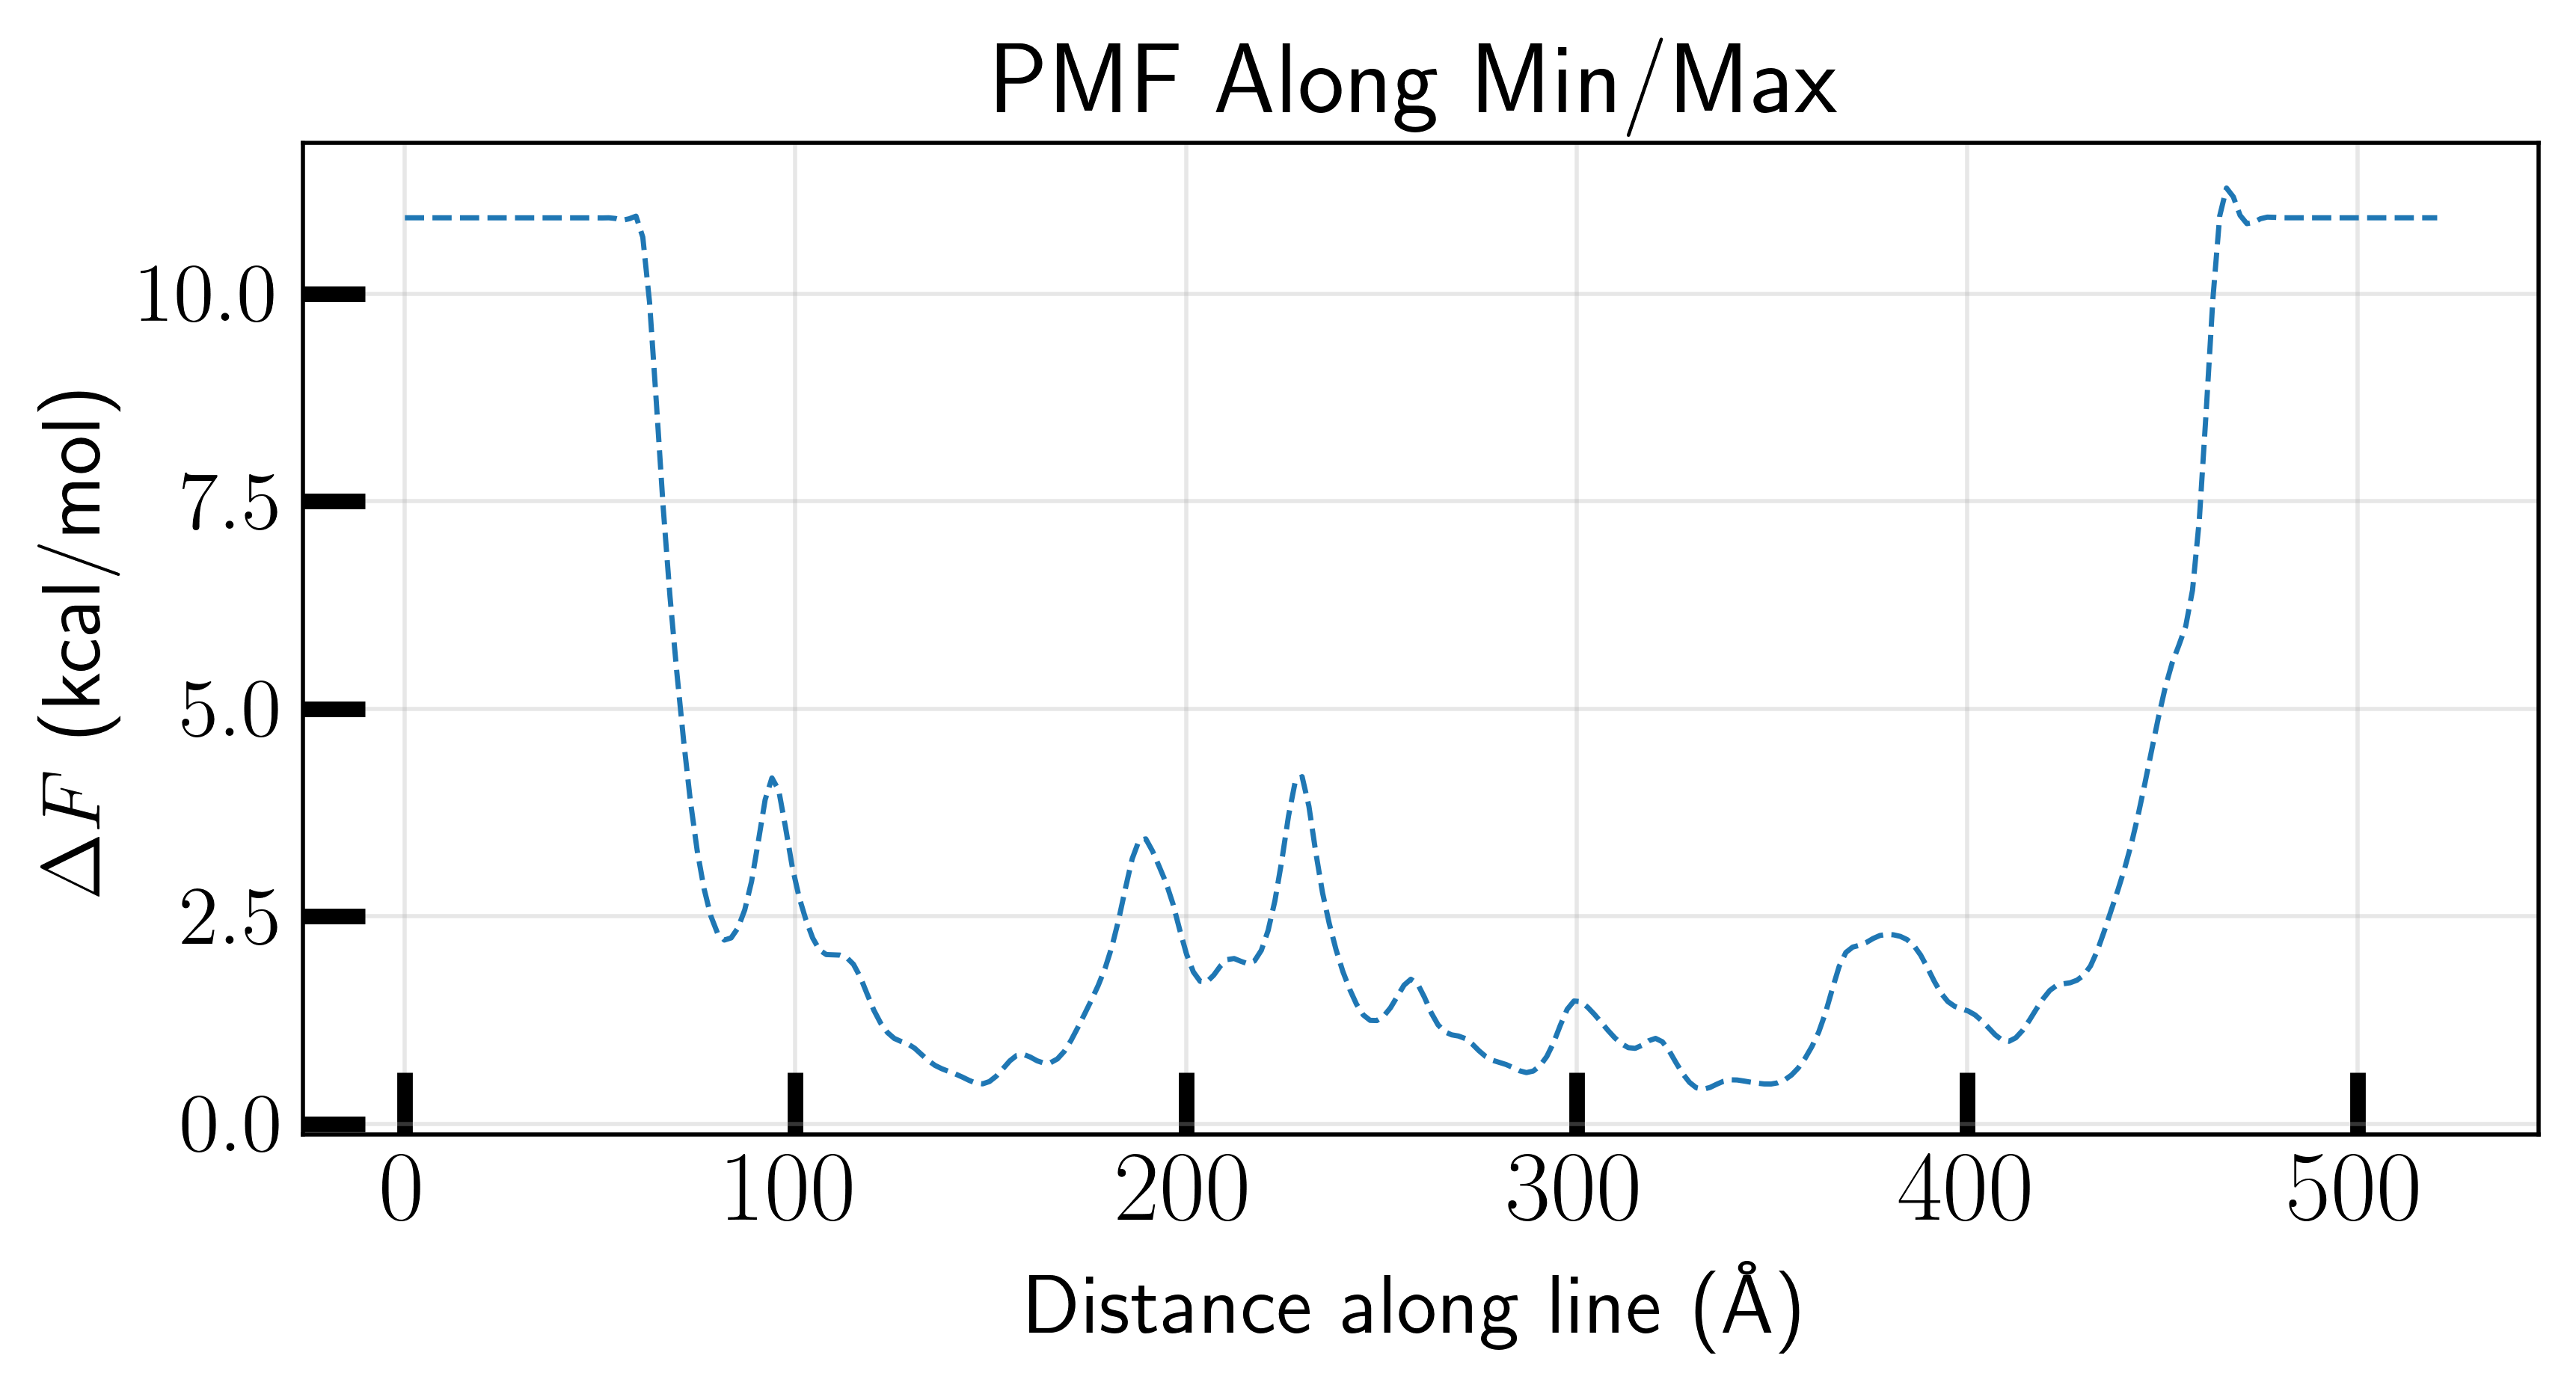

In [56]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

# sample PMF along straight line joining global minimum and maximum of F
# relies on existing variables: F, Xc, Yc, plt, np
# extend the line so it spans the full rectangular grid defined by Xc and Yc

# get global min (should already exist) and compute global max index from F
max_idx_local = np.unravel_index(np.nanargmax(F), F.shape)
p_min = np.array([float(xmin), float(ymin)])
# choose how to read the max coordinate depending on whether X/Y mesh exist
if 'X' in globals() and 'Y' in globals():
    p_max = np.array([float(X[max_idx_local]), float(Y[max_idx_local])])
else:
    p_max = np.array([float(Xc[max_idx_local[0]]), float(Yc[max_idx_local[1]])])

d = p_max - p_min
# if direction is degenerate, fall back to diagonal
if np.allclose(d, 0):
    d = np.array([Xc.max() - Xc.min(), Yc.max() - Yc.min()])

# grid bounding box
xmin_grid, xmax_grid = float(Xc.min()), float(Xc.max())
ymin_grid, ymax_grid = float(Yc.min()), float(Yc.max())

t_candidates = []

# intersections with vertical grid boundaries (x = const)
if not np.isclose(d[0], 0.0):
    for xb in (xmin_grid, xmax_grid):
        t = (xb - p_min[0]) / d[0]
        y_at_t = p_min[1] + t * d[1]
        if (y_at_t >= ymin_grid - 1e-8) and (y_at_t <= ymax_grid + 1e-8):
            t_candidates.append(t)

# intersections with horizontal grid boundaries (y = const)
if not np.isclose(d[1], 0.0):
    for yb in (ymin_grid, ymax_grid):
        t = (yb - p_min[1]) / d[1]
        x_at_t = p_min[0] + t * d[0]
        if (x_at_t >= xmin_grid - 1e-8) and (x_at_t <= xmax_grid + 1e-8):
            t_candidates.append(t)

# if no valid intersection found (numerical issues), clamp to box corners
if len(t_candidates) == 0:
    # compute t for corners and keep those that map inside bbox
    corners = [
        (xmin_grid, ymin_grid),
        (xmin_grid, ymax_grid),
        (xmax_grid, ymin_grid),
        (xmax_grid, ymax_grid),
    ]
    for (xc, yc) in corners:
        # solve p_min + t*d = corner => if d component nearly zero skip accordingly
        valid = True
        t_vals = []
        if not np.isclose(d[0], 0.0):
            t_vals.append((xc - p_min[0]) / d[0])
        if not np.isclose(d[1], 0.0):
            t_vals.append((yc - p_min[1]) / d[1])
        if len(t_vals) == 0:
            continue
        # require consistency (all t within tolerance)
        if np.max(t_vals) - np.min(t_vals) < 1e-6:
            t_candidates.append(np.mean(t_vals))

# pick t range and compute extended endpoints
t_min, t_max = (min(t_candidates), max(t_candidates)) if len(t_candidates) > 0 else (0.0, 1.0)
p_ext1 = p_min + t_min * d
p_ext2 = p_min + t_max * d

# set the values that the rest of the cell expects
xmin_val, ymin_val = float(p_ext1[0]), float(p_ext1[1])
xmax_val, ymax_val = float(p_ext2[0]), float(p_ext2[1])

# sample points along the extended line
npts = 300
xs = np.linspace(xmin_val, xmax_val, npts)
ys = np.linspace(ymin_val, ymax_val, npts)

# spline interpolation on grid defined by Xc (x axis) and Yc (y axis)
def interp_grid(F, x_centers, y_centers, xv, yv):
    # convert to arrays
    x = np.asarray(x_centers, dtype=float)
    y = np.asarray(y_centers, dtype=float)
    z = np.asarray(F, dtype=float)

    # sort axes if necessary (RectBivariateSpline requires increasing coords)
    ix = np.argsort(x)
    iy = np.argsort(y)
    x_s = x[ix]
    y_s = y[iy]
    z_s = z[np.ix_(ix, iy)]

    # choose spline degrees (cannot exceed number of points-1)
    kx = min(3, len(x_s) - 1)
    ky = min(3, len(y_s) - 1)

    spline = RectBivariateSpline(x_s, y_s, z_s, kx=kx, ky=ky, s=0)

    # clamp query points to grid bbox to avoid extrapolation artefacts
    xv_clamped = np.clip(np.asarray(xv, dtype=float), x_s[0], x_s[-1])
    yv_clamped = np.clip(np.asarray(yv, dtype=float), y_s[0], y_s[-1])

    # evaluate; grid=False expects xv and yv to have the same shape and returns 1D array
    return spline(xv_clamped, yv_clamped, grid=False)
    
# interpolate F along line (F is in kcal/mol)
F_line_kcal = interp_grid(F, Xc, Yc, xs, ys)

# distance along line (Å)
dists = np.sqrt((xs - xs[0])**2 + (ys - ys[0])**2)

# plot in kcal/mol
plt.figure(figsize=(7,4))
plt.plot(dists, F_line_kcal, lw=1.0, linestyle='--')
plt.xlabel('Distance along line (Å)')
plt.ylabel(r'$\Delta F$ (kcal/mol)')
plt.title('PMF Along Min/Max')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_701686/1532950666.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


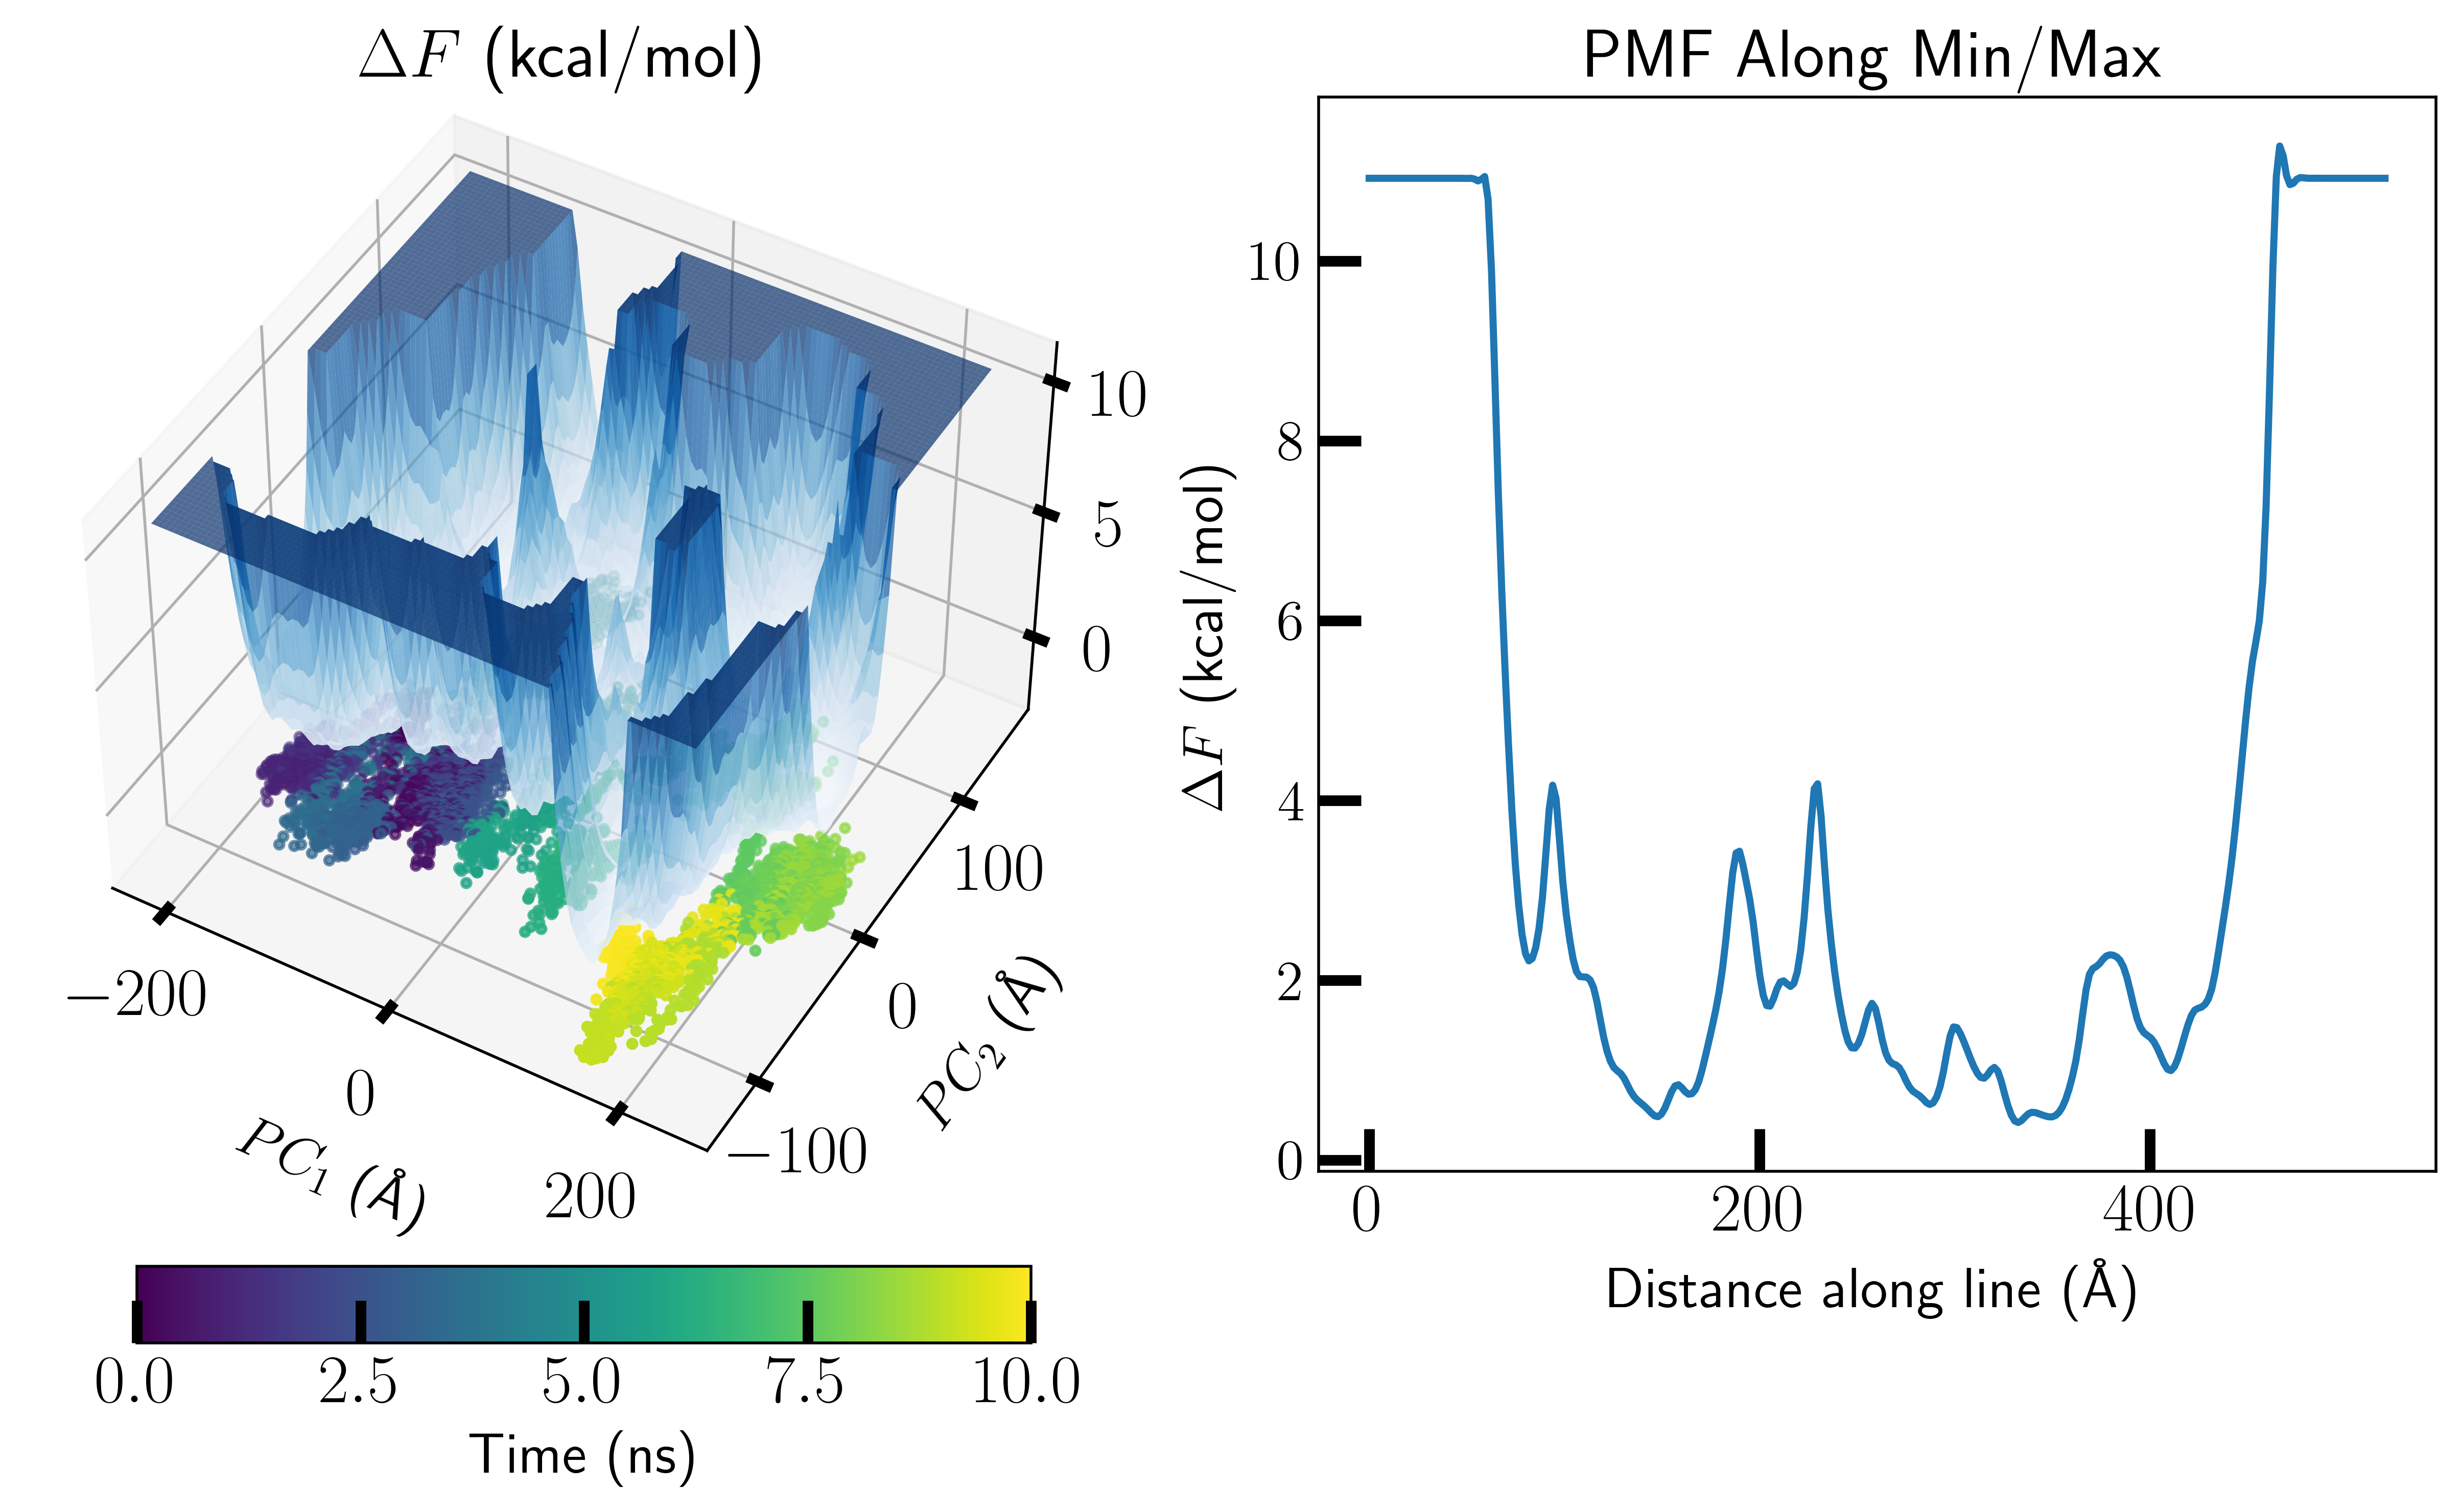

In [ ]:
from matplotlib import gridspec

# 3D Free Energy Landscape (FEL) vs PC1-PC2
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
# create figure and axes using the previously defined GridSpec
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax2 = fig.add_subplot(gs[0, 1])

# Use existing grid X, Y and FEL F (F was set so global min = 0)
surf = ax1.plot_surface(X, Y, F.T, cmap='Blues',linewidth=0, antialiased=True, rstride=1, cstride=1, alpha=0.7)

# add contour projection onto base (z=0)
#ax1.contour(X, Y, F.T, zdir='z', offset=0.0, levels=levels, colors='k', linewidths=0.6, alpha=0.6)

# place a narrow horizontal colorbar below the 3D plot
sc = ax1.scatter(proj[:, 0], proj[:, 1], -3, c=t_ns, s=6, cmap='viridis')

# compute a narrow axes just below ax1
pos = ax1.get_position()
cax = fig.add_axes([pos.x0-0.05, pos.y0 - 0.07, pos.width, 0.03])  # [left, bottom, width, height]

cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label('Time (ns)')
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.xaxis.set_ticks_position('bottom')
#fig.colorbar(sc, label='Time (ns)', shrink=0.3, pad=0.12, ax=ax1)

ax1.set_xlabel(r'$PC_1$  (Å)', labelpad=10)
ax1.set_ylabel(r'$PC_2$  (Å)', labelpad=10)
ax1.set_title(r'$\Delta F$ (kcal/mol)')
ax1.set_zlim(-3, min(F.max()*1.05, 20.0))  # clip for nicer view if F is large
# view angle
ax1.view_init(elev=45, azim=-60)

#cbar = fig.colorbar(surf, ax=ax1, shrink=0.6, pad=0.12)

ax2.plot(dists, F_line_kcal, lw=2.0)
ax2.set_title('PMF Along Min/Max')

ax2.set_xlabel('Distance along line (Å)')
ax2.set_ylabel(r'$\Delta F$ (kcal/mol)')

plt.tight_layout()
plt.show()

Note: The trajectory hasn't properly equilibrated yet, since it starts from near the minimum and finishes away from it. It probably should run for longer...